In [2]:
import geopandas as gpd
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import rasterio
import seaborn as sns
from matplotlib import cm

In [3]:
# %matplotlib widget
# %matplotlib inline


### Read satellite imagery

In [4]:
dataset_list = [rasterio.open(f'./data/tiff/landsat8/LC08_L1TP_120030_20180910_20200830_02_T1_B{i}.tif') for i in range(1, 12)]
dataset_list

[<open DatasetReader name='./data/tiff/landsat8/LC08_L1TP_120030_20180910_20200830_02_T1_B1.tif' mode='r'>,
 <open DatasetReader name='./data/tiff/landsat8/LC08_L1TP_120030_20180910_20200830_02_T1_B2.tif' mode='r'>,
 <open DatasetReader name='./data/tiff/landsat8/LC08_L1TP_120030_20180910_20200830_02_T1_B3.tif' mode='r'>,
 <open DatasetReader name='./data/tiff/landsat8/LC08_L1TP_120030_20180910_20200830_02_T1_B4.tif' mode='r'>,
 <open DatasetReader name='./data/tiff/landsat8/LC08_L1TP_120030_20180910_20200830_02_T1_B5.tif' mode='r'>,
 <open DatasetReader name='./data/tiff/landsat8/LC08_L1TP_120030_20180910_20200830_02_T1_B6.tif' mode='r'>,
 <open DatasetReader name='./data/tiff/landsat8/LC08_L1TP_120030_20180910_20200830_02_T1_B7.tif' mode='r'>,
 <open DatasetReader name='./data/tiff/landsat8/LC08_L1TP_120030_20180910_20200830_02_T1_B8.tif' mode='r'>,
 <open DatasetReader name='./data/tiff/landsat8/LC08_L1TP_120030_20180910_20200830_02_T1_B9.tif' mode='r'>,
 <open DatasetReader name='.

In [5]:
dataset_list[0].transform

Affine(30.0, 0.0, 326685.0,
       0.0, -30.0, 4900215.0)

In [6]:
dataset_list[0].read().shape

(1, 7941, 7811)

In [7]:
dataset_list[0].crs.to_string()

'EPSG:32651'

In [8]:
dataset_list[0].meta


{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 7811,
 'height': 7941,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 51N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32651"]]'),
 'transform': Affine(30.0, 0.0, 326685.0,
        0.0, -30.0, 4900215.0)}

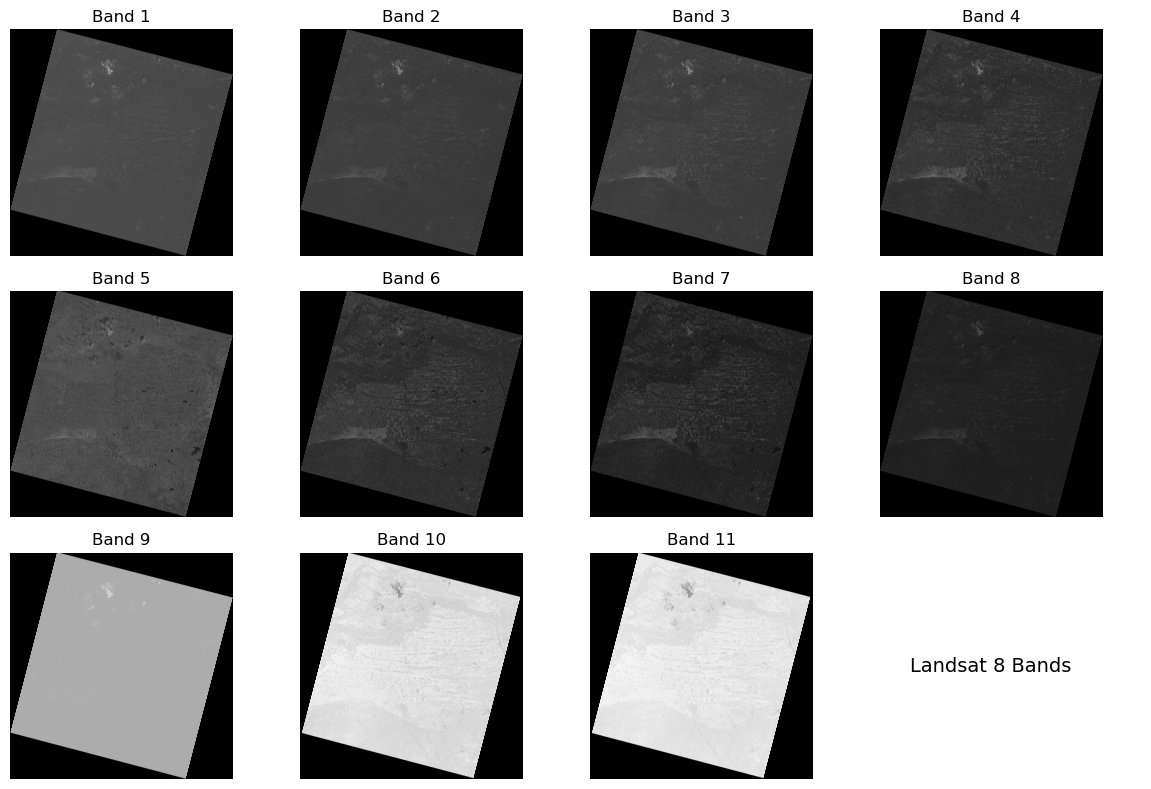

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8), dpi=100)
ax = axes.flatten()

# for index in range(len(dataset_list)):
#     ax[index].imshow(dataset_list[index].read()[0, :, :])
#     ax[index].set_title(f"band{index+1}")

for index in range(len(dataset_list)):
    ax[index].imshow(dataset_list[index].read(1), cmap="gray")
    ax[index].set_title(f"Band {index+1}")
    ax[index].axis("off")

# Use the last subplot for a title or a summary image
ax[11].text(0.5, 0.5, "Landsat 8 Bands", fontsize=14, ha="center", va="center")
ax[11].axis("off")

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()


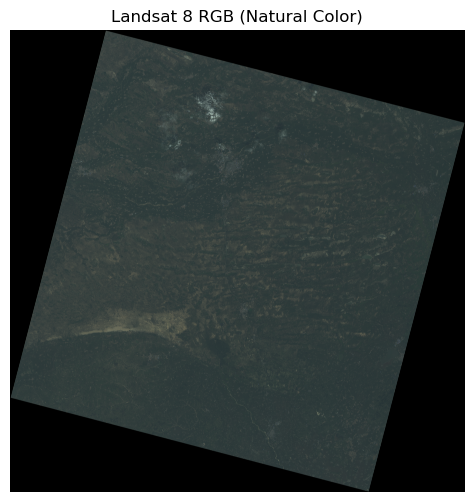

In [10]:

bands = [4, 3, 2]  # Landsat 8 波段索引（从 1 开始）

# 读取并归一化到 0-255
images = np.stack([
    (dataset_list[i-1].read(1) / dataset_list[i-1].read(1).max() * 255).astype(np.uint8) 
    for i in bands
], axis=-1)  # 使其变成 (height, width, 3)，即 RGB 图像


fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(images)
ax.set_title("Landsat 8 RGB (Natural Color)")
ax.axis("off")  # 隐藏坐标轴

plt.show()


Calculating Normalized Difference Vegetation Index

In [11]:

with open("./data/tiff/landsat8/LC08_L1TP_120030_20180910_20200830_02_T1_MTL.txt", "r") as file:
    metadata = file.readlines()

# 提取 ADD_OFFSET 和 MULTIPLIER
ADD_OFFSET = {}
MULTIPLIER = {}

for line in metadata:
    if "REFLECTANCE_ADD_BAND" in line:
        band = line.split("=")[0].split("_")[-1]
        ADD_OFFSET[band] = float(line.split("=")[-1].strip())
    elif "REFLECTANCE_MULT_BAND" in line:
        band = line.split("=")[0].split("_")[-1]
        MULTIPLIER[band] = float(line.split("=")[-1].strip())

print("ADD_OFFSET:", ADD_OFFSET)
print("MULTIPLIER:", MULTIPLIER)


ADD_OFFSET: {'1 ': -0.1, '2 ': -0.1, '3 ': -0.1, '4 ': -0.1, '5 ': -0.1, '6 ': -0.1, '7 ': -0.1, '8 ': -0.1, '9 ': -0.1}
MULTIPLIER: {'1 ': 2e-05, '2 ': 2e-05, '3 ': 2e-05, '4 ': 2e-05, '5 ': 2e-05, '6 ': 2e-05, '7 ': 2e-05, '8 ': 2e-05, '9 ': 2e-05}


In [12]:
# 订正算法，将原始数据转换为反射率，以便进行 NDVI 计算
# 选择 Band 4 (红光) 和 Band 5 (近红外)
band_4 = 4
band_5 = 5

# 读取波段数据并进行反射率转换
Red = dataset_list[band_4 - 1].read(1) * MULTIPLIER[f'{band_4} '] + ADD_OFFSET[f'{band_4} ']
NIR = dataset_list[band_5 - 1].read(1) * MULTIPLIER[f'{band_5} '] + ADD_OFFSET[f'{band_5} ']

ndvi = (NIR - Red) / (NIR + Red)

# 限制 NDVI 范围在 [-1, 1] 内
ndvi = np.clip(ndvi, -1, 1)




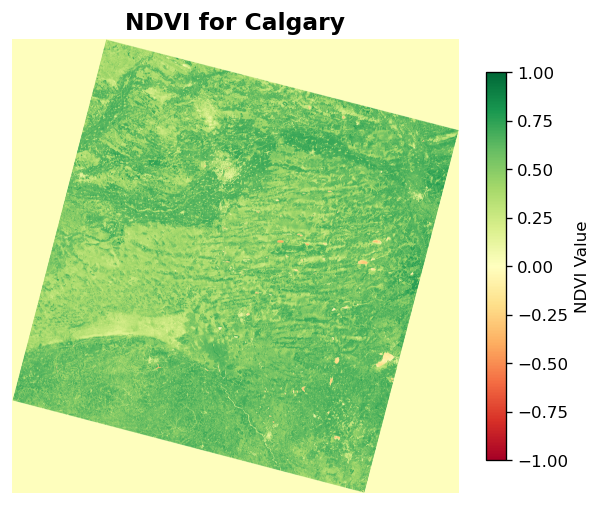

In [13]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=120)  
im = ax.imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)  # 使用 NDVI 颜色映射
ax.set_title("NDVI for Calgary", fontsize=14, fontweight="bold")
ax.axis("off")  # 隐藏坐标轴

cbar = fig.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label("NDVI Value")

plt.show()